In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import sys
from sklearn.random_projection import GaussianRandomProjection
from tqdm import tqdm

sys.path.append('../')
sys.path.append('../src/')
from src.generative import Sphere, Memorizer, Mixture, MultivariateGaussian
from src.detection import DataCopyingDetector

In [2]:
# Set LaTeX for text rendering and configure Palatino fonts
rc('text', usetex=True)  # Enable LaTeX rendering
rc('font', family='serif')  # Use serif fonts
rc('font', serif='Palatino')  # Set Palatino as the serif font

# Add dsfont package to the LaTeX preamble for double-struck symbols
plt.rcParams['text.latex.preamble'] = r'\usepackage{dsfont}'

# Set plotting style and font sizes
plt.rcParams.update({
    'font.size': 10,          # Base font size
    'axes.titlesize': 9,     # Title size
    'axes.labelsize': 8,     # Axis labels size
    'xtick.labelsize': 7,    # X-axis tick labels size
    'ytick.labelsize': 7     # Y-axis tick labels size
})

# Define line styles, colors, markers
line_styles = ['-', '--', ':']
colors = sns.color_palette('colorblind')
markers = ['x', '^', 'h', '^', 'v', '>', '<', 'p', '*', 'h']
markersize = [5, 4, 3, 2, 1]

# Calculate textwidth in inches for plot sizing
textwidth_in_inches = 398.33864 / 72.27


# Sphere

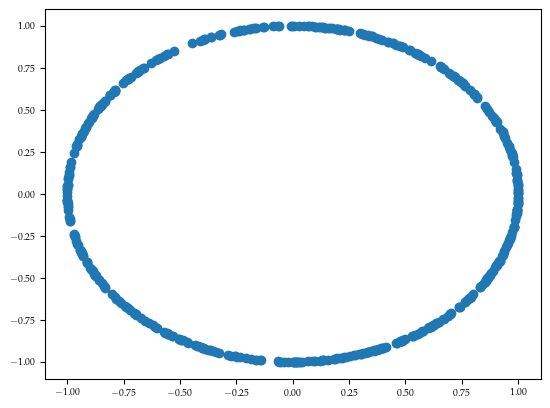

In [3]:
# Visualization in two dimensions
p = Sphere(d=2)
X = p.sample(500)

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [ ]:
# small d seem not to be working
for d in [2, 4, 5, 10, 20, 50]:
    p = Sphere(d=d)
    X = p.sample(20000)
    det = DataCopyingDetector()
    print(f"Estimated data copying rate for d={d}: {det.estimate_cr(X, p, m=20000)}")

__Analysis:__ 

- Copying Rate for small dimensions, i.e. $\mathcal{R}^{d}$ with $d \leq 5$ is not zero which is an unwanted behaviour. Reason: Intrinsic dimension is $d-1$.
- Same goes for $\mathcal{R}^{d}$ with $d \geq 20)$. $\gamma$ is too large resulting to classification of generated points of the true distribution as data copies. So there would be the need to adjust it.

In [ ]:
# check regularity for different d
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, d in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    p = Sphere(d=d) 
    X = p.sample(2000)
    radii = np.logspace(-2, 0, 100)
    counts = np.zeros((len(radii), len(X)))
    for k, x in enumerate(X):
        for j, r in enumerate(radii):
            counts[j, k] = np.sum(np.linalg.norm(X - x, axis=1) < r)

    axs[i // 3, i % 3].plot(radii, np.mean(counts, axis=1))
    axs[i // 3, i % 3].set_title(f"d={d}")
    axs[i // 3, i % 3].fill_between(radii, np.mean(counts, axis=1) - np.std(counts, axis=1), np.mean(counts, axis=1) + np.std(counts, axis=1), alpha=0.3)
plt.show()

In [4]:
ds = [10, 25, 50, 75, 100]
d_projs = [1, 2, 3]
k = 10
n = 20000
rhos = np.round(np.linspace(0, 1, 11), 2)
copier = Memorizer()

In [5]:
# results = np.zeros((n, k, len(ds), len(d_projs), len(rhos))).astype(bool)

# for i, d in enumerate(ds):
#     p = Sphere(d=d)
#     X = p.sample(n)
#     for j, r in enumerate(tqdm(rhos)):
#         q = Mixture(rho=r, q1=copier, q2=p).fit(X)
#         X1_gen = q.sample(n)
#         X2_gen = q.sample(n)
#         for l, d_proj in enumerate(d_projs):
#             for m in range(k):
#                 rp = GaussianRandomProjection(n_components=d_proj).fit(X)
#                 dcd = DataCopyingDetector()
#                 idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X1_gen), rp.transform(X2_gen))
#                 results[idx, m, i, l, j] = True

# # save results
# np.save('../doc/exp/Sphere/mixed_model_results.npy', results)

In [6]:
### plotting
results = np.load('../doc/exp/Sphere/mixed_model_results.npy')
majority_votes = (results.mean(axis=1) > 0.5).mean(axis=0)

line_styles = ['--', '-.', ':']
markers = ['.', '^', 'x', 's']
colors = sns.color_palette('colorblind')
fig, axs = plt.subplots(2, 3, figsize=(textwidth_in_inches, 3), sharex=True, sharey=True)
axs = axs.flatten()

for i, d in enumerate(ds):
    axs[i].plot(rhos, rhos, label='True $cr_q$', linestyle='-', color='black')
    for j, d_proj in enumerate(d_projs):
        # plot ground truth
        axs[i].plot(rhos, majority_votes[i, j], label='$d_{\\mathrm{proj}}=$' + str(d_proj), linestyle=line_styles[j], marker=markers[j], markersize=5, color=colors[j])
    # title is (a), (b), (c), ...
    axs[i].set_title(f"({chr(97 + i)}) $d={d}$")

# labeling axis in first column and last row
axs[0].set_ylabel('$cr_q$')
axs[3].set_ylabel('$cr_q$')
axs[3].set_xlabel('$\\rho$')
axs[4].set_xlabel('$\\rho$')

axs[5].axis('off')
handles, labels = axs[0].get_legend_handles_labels()
axs[5].legend(handles, labels, loc='center')

plt.tight_layout(pad=0.5)
plt.savefig('../doc/figures/Sphere/majority_votes.png', dpi=300)
plt.close()

# Multivariate Gaussian

In [7]:
ds = [10, 25, 50, 75, 100]
d_projs = [1, 2, 3]
k = 10
n = 20000
rhos = np.round(np.linspace(0, 1, 11), 2)
copier = Memorizer()

In [8]:
# results = np.zeros((n, k, len(ds), len(d_projs), len(rhos))).astype(bool)

# for i, d in enumerate(ds):
#     p = MultivariateGaussian(dim=d)
#     X = p.sample(n)
#     for j, r in enumerate(tqdm(rhos)):
#         q = Mixture(rho=r, q1=copier, q2=p).fit(X)
#         X1_gen = q.sample(n)
#         X2_gen = q.sample(n)
#         for l, d_proj in enumerate(d_projs):
#             for m in range(k):
#                 rp = GaussianRandomProjection(n_components=d_proj).fit(X)
#                 dcd = DataCopyingDetector()
#                 idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X1_gen), rp.transform(X2_gen))
#                 results[idx, m, i, l, j] = True


# # save results
# np.save('../doc/exp/MultivariateGaussian/mixed_model_results.npy', results)

In [9]:
### plotting
results = np.load('../doc/exp/MultivariateGaussian/mixed_model_results.npy')
majority_votes = (results.mean(axis=1) > 0.5).mean(axis=0)

line_styles = ['--', '-.', ':']
markers = ['.', '^', 'x', 's']
colors = sns.color_palette('colorblind')
fig, axs = plt.subplots(2, 3, figsize=(textwidth_in_inches, 3), sharex=True, sharey=True)
axs = axs.flatten()

for i, d in enumerate(ds):
    axs[i].plot(rhos, rhos, label='True $cr_q$', linestyle='-', color='black')
    for j, d_proj in enumerate(d_projs):
        # plot ground truth
        axs[i].plot(rhos, majority_votes[i, j], label='$d_{\\mathrm{proj}}=$' + str(d_proj), linestyle=line_styles[j], marker=markers[j], markersize=5, color=colors[j])
    axs[i].set_title(f"({chr(97 + i)}) $d={d}$")

# labeling axis in first column and last row
axs[0].set_ylabel('$cr_q$')
axs[3].set_ylabel('$cr_q$')
axs[3].set_xlabel('$\\rho$')
axs[4].set_xlabel('$\\rho$')

axs[5].axis('off')
handles, labels = axs[0].get_legend_handles_labels()
axs[5].legend(handles, labels, loc='center')

plt.tight_layout(pad=0.5)
plt.savefig('../doc/figures/MultivariateGaussian/majority_votes.png', dpi=300)
plt.close()